In [2]:
import os
import yaml
import pickle
import matplotlib
from multiprocessing import Pool
from typing import Dict, List, Tuple, Union
from numbers import Number

import torch
import numpy as np
import matplotlib.pyplot as plt
import bilby
import torch
import pandas as pd
from pprint import pprint
from bilby.gw.conversion import (
    convert_to_lal_binary_black_hole_parameters,
    bilby_to_lalsimulation_spins,
)
from pprint import pprint
import lalinference.imrtgr.nrutils as nrutils
import lal
import scipy

import lalsimulation as LS


matplotlib.use('pdf')
os.environ['MPLCONFIGDIR'] = '/home/local/nihargupte'
import dingo.gw.dataset.generate_dataset 
from dingo.gw.inference import injection
import dingo.gw.training.train_builders
import dingo.gw.waveform_generator
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
from dingo.gw.dataset import WaveformDataset
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.transforms import SelectStandardizeRepackageParameters, RepackageStrainsAndASDS, UnpackDict, SampleExtrinsicParameters, GNPECoalescenceTimes, AddWhiteNoiseComplex
from dingo.core.models import PosteriorModel
import dingo.gw.domains
from dingo.gw.waveform_generator import WaveformGenerator
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler

%load_ext autoreload
%autoreload 2
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-sasd9g23 because the default path (/home/nihargupte/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/local/nihargupte/tgr/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
charizard_hex = ('#cd5241', '#084152', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118', '#eede7b')
meganium_hex = ("#62bd41", "#7b1039", "#624a00", "#f6a49c", "#e6ac00", "#ff395a", "#6a6a6a", "#107b31", )
wobbuffet_hex = ("#20528b", "#525252", "#ff8b00", "#a41000", "#de5200", "#62bd41")
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

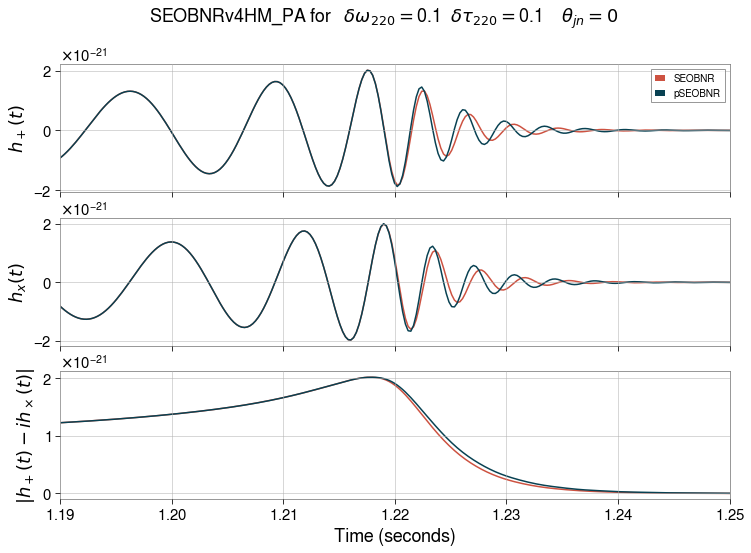

In [77]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)
def _convert_to_scalar(x: Union[np.ndarray, float]) -> Number:
    """
    Convert a single element array to a number.

    Parameters
    ----------
    x:
        Array or number

    Returns
    -------
    A number
    """
    if isinstance(x, np.ndarray):
        if x.shape == () or x.shape == (1,):
            return x.item()
        else:
            raise ValueError(
                f"Expected an array of length one, but shape = {x.shape}"
            )
    else:
        return x

def convert_parameters_to_lal_frame(parameter_dict: Dict, approximant, domain_dict, lal_params=None) -> Tuple:
    """Convert to lal source frame parameters

    Parameters
    ----------
    parameter_dict : Dict
        A dictionary of parameter names and 1-dimensional prior distribution
        objects. If None, we use a default binary black hole prior.
    lal_params : (None, or Swig Object of type 'tagLALDict *')
        Extra parameters which can be passed to lalsimulation calls.

    Returns
    -------
    lal_parameter_tuple:
        A tuple of parameters for the lalsimulation waveform generator
    """
    # Transform mass, spin, and distance parameters
    p, _ = convert_to_lal_binary_black_hole_parameters(parameter_dict)

    # Convert to SI units
    p["mass_1"] *= lal.MSUN_SI
    p["mass_2"] *= lal.MSUN_SI
    p["luminosity_distance"] *= 1e6 * lal.PC_SI

    # Transform to lal source frame: iota and Cartesian spin components
    param_keys_in = (
        "theta_jn",
        "phi_jl",
        "tilt_1",
        "tilt_2",
        "phi_12",
        "a_1",
        "a_2",
        "mass_1",
        "mass_2",
        "f_ref",
        "phase",
    )
    param_values_in = [p[k] for k in param_keys_in]
    iota_and_cart_spins = bilby_to_lalsimulation_spins(*param_values_in)
    iota, s1x, s1y, s1z, s2x, s2y, s2z = [
        float(_convert_to_scalar(x)) for x in iota_and_cart_spins
    ]

    # Construct argument list for FD and TD lal waveform generator wrappers
    spins_cartesian = s1x, s1y, s1z, s2x, s2y, s2z
    masses = (p["mass_1"], p["mass_2"])
    extra_params = (p["luminosity_distance"], iota, p["phase"])
    ecc_params = (0.0, 0.0, 0.0)  # longAscNodes, eccentricity, meanPerAno

    if "delta_t" in domain_dict.keys():
        domain_pars = (domain_dict["delta_t"], domain_dict["f_min"], domain_dict["f_ref"])
    elif "delta_f" in domain_dict.keys():
        domain_pars = ((domain_dict["delta_f"], domain_dict["f_start"], domain_dict["f_max"], domain_dict["f_ref"]))

    lal_parameter_tuple = (
        masses
        + spins_cartesian
        + extra_params
        + ecc_params
        + domain_pars
        + (lal_params, approximant)
    )
    return lal_parameter_tuple

def setup_mode_array(mode_list: List) -> lal.Dict:
    """
    Define a LALSimulation "ModeArray" to select waveform modes
    to include in the polarizations from a list of modes.

    Parameters
    ----------
    mode_list : List
        a list of (ell, m) modes

    Returns
    -------
    lal_params : lal.Dict
    """
    lal_params = lal.CreateDict()
    ma = LS.SimInspiralCreateModeArray()
    for (ell, m) in mode_list:
        LS.SimInspiralModeArrayActivateMode(ma, ell, m)
    LS.SimInspiralWaveformParamsInsertModeArray(lal_params, ma)
    return lal_params

def SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array="*"):
    if mode_array == "*":
        lal_dict = lal.CreateDict()
    else:
        lal_dict = setup_mode_array(mode_array)

    approximant = LS.SEOBNRv4HM_PA
    LS.SimInspiralWaveformParamsInsertDOmega220(lal_dict, parameters["domega220"])
    LS.SimInspiralWaveformParamsInsertDTau220(lal_dict, parameters["dtau220"])
    parameters_lal = convert_parameters_to_lal_frame(parameters, approximant, domain_dict, lal_dict)
    hp, hc = LS.SimInspiralTD(*parameters_lal)
    h_plus = hp.data.data
    h_cross = hc.data.data
    return {"h_plus": h_plus, "h_cross": h_cross}

parameters = {
    "phase": 0.,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 31.6, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.,
    "chi_2": 0.,
    "theta_jn": 0,
    "luminosity_distance": 410., #Mpc
    "domega220": 0.,
    "dtau220": 0.
}

domain_dict = {
    "f_min": 20,
    "f_ref": 20,
    "f_max": 1024
}

time_duration = 8.0
sampling_rate = 2 * 2 * domain_dict["f_max"]
domain_dict["delta_t"] = 1 / sampling_rate

wf_dict_normal = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=[(2, 2), (2, 1), (3, 3), (4, 4), (5, 5)])
time_normal = 0 + np.arange(wf_dict_normal["h_plus"].shape[0]) * domain_dict["delta_t"]

parameters["domega220"] = 0.1
parameters["dtau220"] = 0.1

wf_dict_perturbed = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=[(2, 2), (2, 1), (3, 3), (4, 4), (5, 5)])
time_perturbed = 0 + np.arange(wf_dict_perturbed["h_plus"].shape[0]) * domain_dict["delta_t"]

wf_dicts = {"SEOBNR": {"waveform":wf_dict_normal, "time":time_normal}, "pSEOBNR": {"waveform":wf_dict_perturbed, "time":time_perturbed}}

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA for   $\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}    " + r"$\theta_{jn} = 0$")

for label, wf_dict in wf_dicts.items():
    wf = wf_dict["waveform"]
    time = wf_dict["time"]
    axes[0].plot(time, wf["h_plus"], label=label)
    strain_amplitude = np.sqrt(wf["h_plus"]**2 + wf["h_cross"]**2)
    axes[1].plot(time, wf["h_cross"], label=label)
    axes[2].plot(time, strain_amplitude, label=label)

axes[0].set_ylabel(r"$h_+(t)$")
axes[1].set_ylabel(r"$h_x(t)$")
axes[2].set_ylabel(r"$|h_+(t) - i h_\times(t)|$")
axes[0].legend()
plt.xlabel("Time (seconds)")
plt.xlim([1.19, 1.25])
plt.subplots_adjust(wspace=0, hspace=0.2)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/TD_1.pdf")

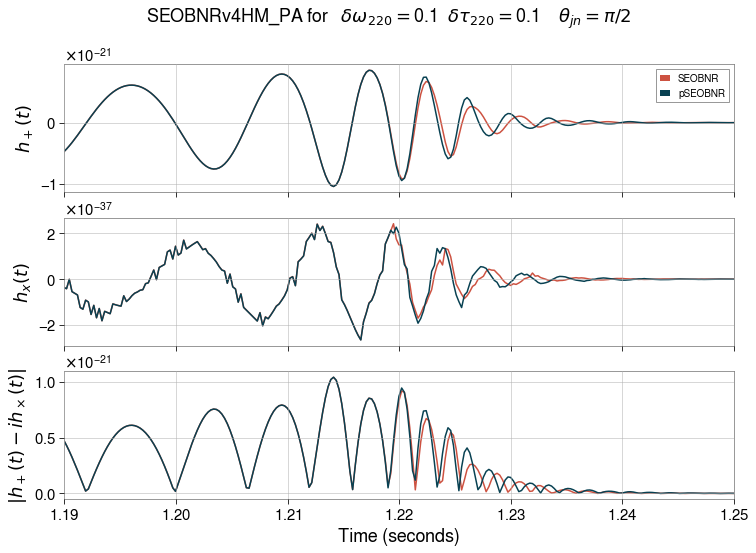

In [78]:
parameters = {
    "phase": 0.,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 31.6, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.,
    "chi_2": 0.,
    "theta_jn": np.pi / 2,
    "luminosity_distance": 410., #Mpc
    "domega220": 0.,
    "dtau220": 0.
}

wf_dict_normal = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=[(2, 2), (2, 1), (3, 3), (4, 4), (5, 5)])
time_normal = 0 + np.arange(wf_dict_normal["h_plus"].shape[0]) * domain_dict["delta_t"]

parameters["domega220"] = 0.1
parameters["dtau220"] = 0.1

wf_dict_perturbed = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=[(2, 2), (2, 1), (3, 3), (4, 4), (5, 5)])
time_perturbed = 0 + np.arange(wf_dict_perturbed["h_plus"].shape[0]) * domain_dict["delta_t"]

wf_dicts = {"SEOBNR": {"waveform":wf_dict_normal, "time":time_normal}, "pSEOBNR": {"waveform":wf_dict_perturbed, "time":time_perturbed}}

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA for   $\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}    " + r"$\theta_{jn} = \pi/2$")

for label, wf_dict in wf_dicts.items():
    wf = wf_dict["waveform"]
    time = wf_dict["time"]
    axes[0].plot(time, wf["h_plus"], label=label)
    strain_amplitude = np.sqrt(wf["h_plus"]**2 + wf["h_cross"]**2)
    axes[1].plot(time, wf["h_cross"], label=label)
    axes[2].plot(time, strain_amplitude, label=label)

axes[0].set_ylabel(r"$h_+(t)$")
axes[1].set_ylabel(r"$h_x(t)$")
axes[2].set_ylabel(r"$|h_+(t) - i h_\times(t)|$")
axes[0].legend()
plt.xlabel("Time (seconds)")
plt.xlim([1.19, 1.25])
plt.subplots_adjust(wspace=0, hspace=0.2)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/TD_2.pdf")

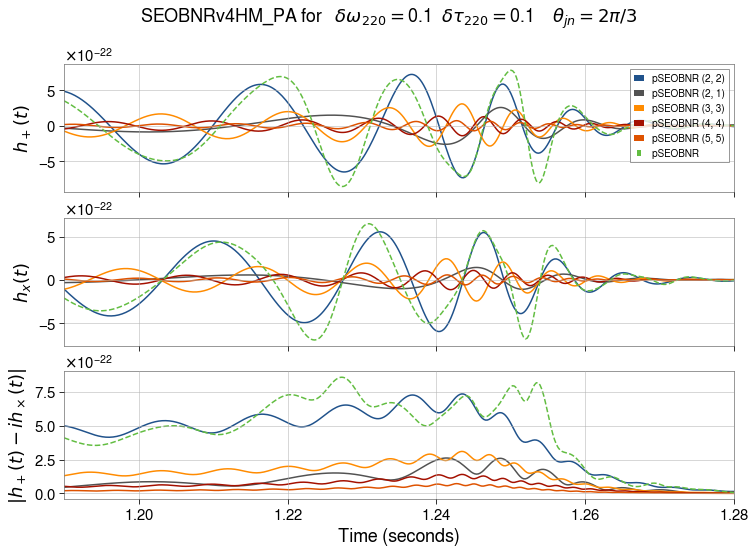

In [79]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wobbuffet_hex)
parameters = {
    "phase": 0.,
    "chirp_mass": 30.0,
    "mass_ratio": 0.1,
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.,
    "chi_2": 0.,
    "theta_jn": 2*np.pi/3,
    "luminosity_distance": 410., #Mpc
    "domega220": 0.1,
    "dtau220": 0.1
}

mode_list = [
    [(2, 2)],
    [(2, 1)],
    [(3, 3)],
    [(4, 4)],
    [(5, 5)],
]
mode_list.append([m[0] for m in mode_list])

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA for   $\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}    " + r"$\theta_{jn} = 2\pi/3$")

for modes in mode_list:
    wf = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=modes)
    time = 0 + np.arange(wf["h_plus"].shape[0]) * domain_dict["delta_t"]

    if len(modes) > 1:
        mode = ""
        linestyle="--"
    else:
        mode = modes[0]
        linestyle="-"
    label = f"pSEOBNR {mode}"
    axes[0].plot(time, wf["h_plus"], label=label, linestyle=linestyle)
    strain_amplitude = np.sqrt(wf["h_plus"]**2 + wf["h_cross"]**2)
    axes[1].plot(time, wf["h_cross"], label=label, linestyle=linestyle)
    axes[2].plot(time, strain_amplitude, label=label, linestyle=linestyle)

axes[0].set_ylabel(r"$h_+(t)$")
axes[1].set_ylabel(r"$h_x(t)$")
axes[2].set_ylabel(r"$|h_+(t) - i h_\times(t)|$")
axes[0].legend(loc="upper right")
plt.xlabel("Time (seconds)")
plt.xlim([1.19, 1.28])
plt.subplots_adjust(wspace=0, hspace=0.2)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/TD_higher_modes_2.pdf")

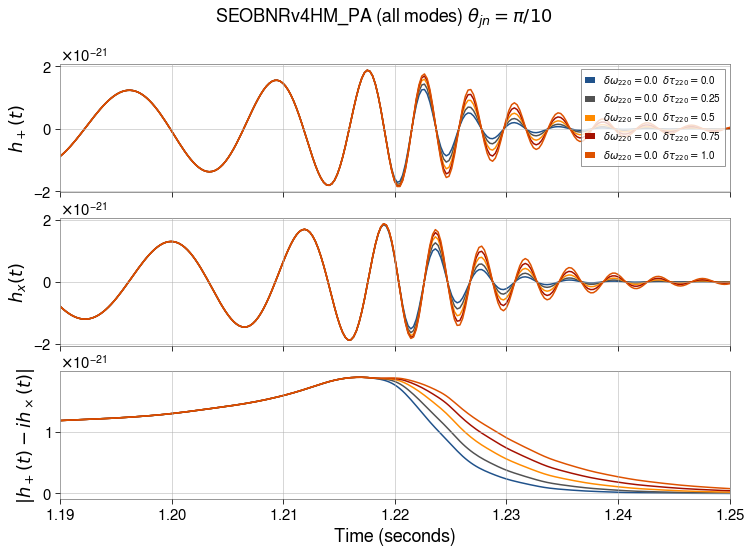

In [80]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wobbuffet_hex)
parameters = {
    "phase": 0.,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 31.6, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.,
    "chi_2": 0.,
    "theta_jn": np.pi/10,
    "luminosity_distance": 410., #Mpc
    "domega220": 0.,
    "dtau220": 0.
}
n_deviations = 5
deviations = {"domega220":np.linspace(0, 0, n_deviations), "dtau220":np.linspace(0, 1, n_deviations)}


fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA (all modes) " + r"$\theta_{jn} = \pi/10$")

for i in range(n_deviations):
    parameters["domega220"] = deviations["domega220"][i]
    parameters["dtau220"] = deviations["dtau220"][i]
    wf = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=[(2, 2), (2, 1), (3, 3), (4, 4), (5, 5)])
    time = 0 + np.arange(wf["h_plus"].shape[0]) * domain_dict["delta_t"]

    label = r"$\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}"
    axes[0].plot(time, wf["h_plus"], label=label)
    strain_amplitude = np.sqrt(wf["h_plus"]**2 + wf["h_cross"]**2)
    axes[1].plot(time, wf["h_cross"], label=label)
    axes[2].plot(time, strain_amplitude, label=label)

axes[0].set_ylabel(r"$h_+(t)$")
axes[1].set_ylabel(r"$h_x(t)$")
axes[2].set_ylabel(r"$|h_+(t) - i h_\times(t)|$")
axes[0].legend(loc="upper right")
plt.xlabel("Time (seconds)")
plt.xlim([1.19, 1.25])
plt.subplots_adjust(wspace=0, hspace=0.2)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/TD_qnm_tau_deviations.pdf")

(1.0230658945071832e-22-2.5602580622747344e-23j) (1.0230658945071832e-22-2.5602580622747344e-23j)
(2.401701712699808e-25-1.4735716929736653e-26j) (2.401701712699808e-25-1.4735716929736653e-26j)
(7.830794497905266e-25-2.2158486320156866e-25j) (7.830794497905266e-25-2.2158486320156866e-25j)
(1.7225802136762492e-25+5.415649135258201e-28j) (1.7225802136762492e-25+5.415649135258201e-28j)
(3.054001528804168e-27-1.013523798243006e-28j) (3.054001528804168e-27-1.013523798243006e-28j)
(1.0249486163239561e-22-2.5739139694426688e-23j) (1.0249486163239561e-22-2.5739139694426688e-23j)


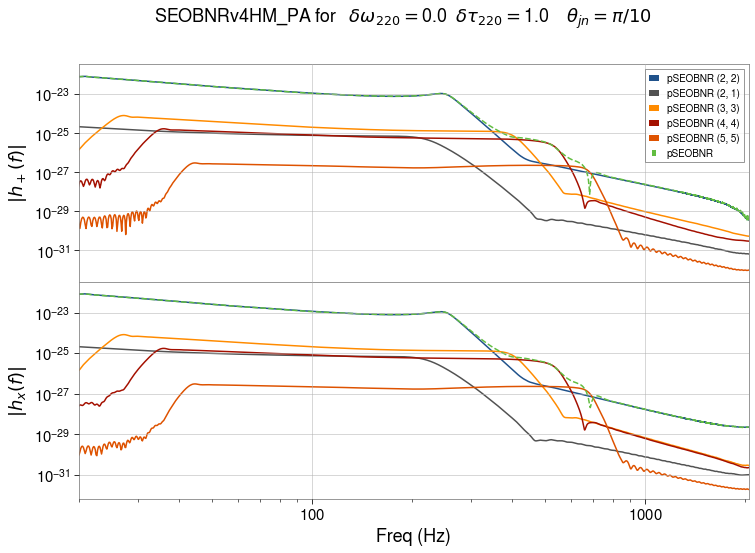

In [82]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wobbuffet_hex)
def SEOBNRv4HM_PA_FD(parameters, domain_dict, mode_array="*"):
    if mode_array == "*":
        lal_dict = lal.CreateDict()
    else:
        lal_dict = setup_mode_array(mode_array)
    approximant = LS.SEOBNRv4HM_PA
    LS.SimInspiralWaveformParamsInsertDOmega220(lal_dict, parameters["domega220"])
    LS.SimInspiralWaveformParamsInsertDTau220(lal_dict, parameters["dtau220"])
    parameters_lal = convert_parameters_to_lal_frame(parameters, approximant, domain_dict, lal_dict)
    # hp, hc = LS.SimInspiralChooseFDWaveform(*parameters_lal)
    hp, hc = LS.SimInspiralFD(*parameters_lal)
    h_plus = hp.data.data
    h_cross = hc.data.data
    return {"h_plus": h_plus, "h_cross": h_cross}

os.environ["LAL_DATA_PATH"] = "/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/lalsimulation/"

domain_dict = {
    "delta_f": 0.125,
    "f_start": 20,
    "f_ref": 20,
    "f_max": 2048
}

mode_list = [
    [(2, 2)],
    [(2, 1)],
    [(3, 3)],
    [(4, 4)],
    [(5, 5)],
    "*"
]
# mode_list.append([m[0] for m in mode_list])

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA for   $\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}    " + r"$\theta_{jn} = \pi/10$")

for modes in mode_list:
    wf = SEOBNRv4HM_PA_FD(parameters, domain_dict, modes)
    print(np.max(wf["h_plus"]), np.max(wf["h_plus"]))
    freq = 0 + np.arange(wf["h_plus"].shape[0]) * domain_dict["delta_f"]

    if modes == "*":
        label = "pSEOBNR"
        linestyle = "--"
    else:
        label = f"pSEOBNR {modes[0]}"
        linestyle = "-"
    axes[0].plot(freq, np.abs(wf["h_plus"]), label=label, linestyle=linestyle)
    axes[1].plot(freq, np.abs(wf["h_cross"]), label=label, linestyle=linestyle)

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_ylabel(r"$|h_+(f)|$")
axes[1].set_ylabel(r"$|h_x(f)|$")
axes[0].legend()
plt.xlim([domain_dict["f_start"], domain_dict["f_max"]])
plt.xscale('log')
plt.xlabel("Freq (Hz)")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/FD_HM.pdf")

6.750774966926144e+31


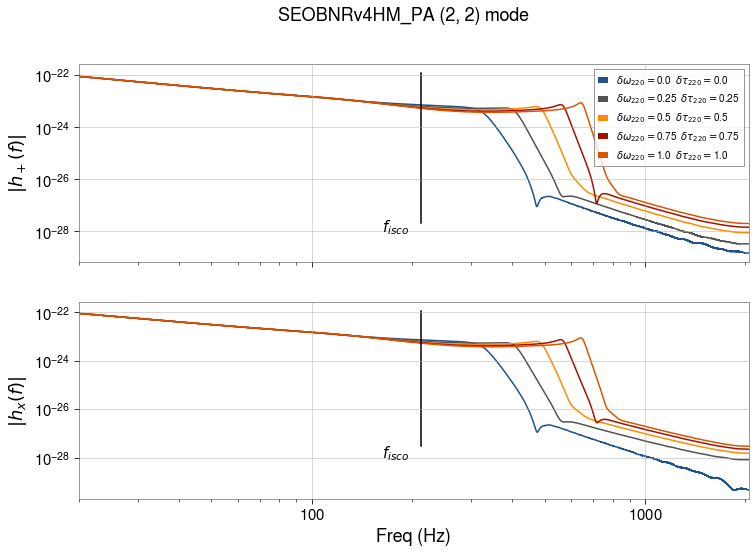

In [85]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wobbuffet_hex)
parameters = {
    "phase": 0.,
    # "mass_ratio": 0.1,
    # "chirp_mass": 30,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 31.6, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.7,
    "chi_2": 0.7,
    "theta_jn": np.pi/10,
    "luminosity_distance": 410., #Mpc
    "domega220": 0.,
    "dtau220": 0.
}

n_deviations = 5
deviations = {"domega220":np.linspace(0, 1, n_deviations), "dtau220":np.linspace(0, 1, n_deviations)}

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA (2, 2) mode")
for i in range(n_deviations):
    parameters["domega220"] = deviations["domega220"][i]
    parameters["dtau220"] = deviations["dtau220"][i]
    wf = SEOBNRv4HM_PA_FD(parameters, domain_dict, mode_array=[(2, 2)])
    freq = 0 + np.arange(wf["h_plus"].shape[0]) * domain_dict["delta_f"]

    label = r"$\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}"
    axes[0].plot(freq, np.abs(wf["h_plus"]), label=label)
    axes[1].plot(freq, np.abs(wf["h_cross"]), label=label)


m1, m2, chi1, chi2 = parameters["mass_1"], parameters["mass_2"], parameters["chi_1"], parameters["chi_2"]
chi_f = nrutils.bbh_final_spin_non_precessing_Healyetal(m1, m2, chi1, chi2, version="2016")
M = nrutils.bbh_final_mass_non_precessing_Healyetal(m1, m2, chi1, chi2, chif=chi_f, version="2016")
r_isco_tilde = nrutils.calc_isco_radius(chi_f)
omega_tilde = 1 / (r_isco_tilde**(3/2) + chi_f)
M_SI = M * lal.MSUN_SI
f_isco = omega_tilde / (np.pi * (M_SI*(lal.G_SI/(lal.C_SI**3))))

axes[0].text(f_isco - 50, 1e-28, r"$f_{isco}$")
axes[0].plot([f_isco, f_isco], [np.min(np.abs(wf["h_plus"])), np.max(np.abs(wf["h_plus"]))], c='k')
axes[1].text(f_isco - 50, 1e-28, r"$f_{isco}$")
axes[1].plot([f_isco, f_isco], [np.min(np.abs(wf["h_cross"])), np.max(np.abs(wf["h_cross"]))], c='k')
axes[1].plot([f_isco_lal, f_isco_lal], [np.min(np.abs(wf["h_cross"])), np.max(np.abs(wf["h_cross"]))], c='g', linestyle="-")

axes[0].set_xlim([domain_dict["f_start"], domain_dict["f_max"]])
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_ylabel(r"$|h_+(f)|$")
axes[1].set_ylabel(r"$|h_x(f)|$")
axes[0].legend()
axes[0].legend(loc="upper right")
plt.xscale("log")
plt.xlabel("Freq (Hz)")
plt.subplots_adjust(wspace=0, hspace=0.2)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/FD_omega.pdf")

In [ ]:
# # Need to find where the cutoff frequency is, this is the frequency of the ISCO corresponding to the remnant Kerr BH
# # Using [1] arXiv:0801.4297

# def f_isco(chi_1, chi_2, mass_ratio):
#     pass 

# def Z_1(a_f, M):
#     A = 1 + ((1 - (a_f/M)**2) ** (1/3))
#     B = ((1 + (a_f/M)) ** (1/3)) + ((1 - (a_f/M)) ** (1/3))
#     print(A)
#     return A * B

# def Z_2(a_f, M):
#     Z1 = Z_1(a_f, M)
#     return (3 * ((a_f/M) ** 2) + (Z_1(a_f, M) ** 2)) ** (1/2)

# # prograde orbit
# def r_isco(a_f, M):
#     Z1 = Z_1(a_f, M)
#     Z2 = Z_2(a_f, M)
#     return M * (3 + Z2 - (((3 - Z1) * (3 + Z1 + 2*Z2)) ** (1/2)))

# # prograde orbit
# def L_orb(a_f, q, M):
#     r = r_isco(a_f, M)
#     num = r**2 - (2 * a_f * M**(1/2) * r**(1/2)) + a_f**2
#     denom = M**(1/2) * r**(3/4) * ((r**(3/2) - 3*M*(r**(1/2)) + 2*a_f*(M**(1/2))) ** (1/2))
#     return (q / ((1 + q) ** 2)) * (num / denom)

# # prograde orbit
# def f_isco(a_f, M):
#     r = r_isco(a_f, M)
#     return (1 / np.pi) * (M ** (1/2)) / ((r ** (3/2)) + (a_f * M **(1/2)))

# M = 50
# a_f = np.linspace(0.1, 0.99, 100)
# plt.plot(a_f, f_isco(a_f, M))
# # def a_f(chi_1, chi_2, q):
# #     LORB = L_orb(a_f)
